## Try to maximize the likelihood using iminuit (compressed params)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import lya_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=15
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 15 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/sim_pair_15/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.7654E-09, n_s = 9.6590E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup LyaTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [6]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=data.mock_sim.sim_cosmo
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=sim_cosmo)
else:
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.cosmo.cosmo_fid)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [7]:
# Likelihood parameters (option to fix cosmology for testing)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0","ln_kF_0"]
    like_param_limits=[[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2]]
else:
    like_params=["Delta2_star","n_star","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [8]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [9]:
# print truth in test simulation
like.get_simulation_linP_params(test_sim_label)

{'f_star': 0.9813909211842693,
 'g_star': 0.9677508863420937,
 'linP_kms': poly1d([-0.10814533, -2.29861294, 15.92231369]),
 'Delta2_star': 0.30364823417031134,
 'n_star': -2.2986129401746167,
 'alpha_star': -0.21629065209715273}

In [10]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
Delta2_star = 0.355
n_star = -2.301
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 979.8041889043435


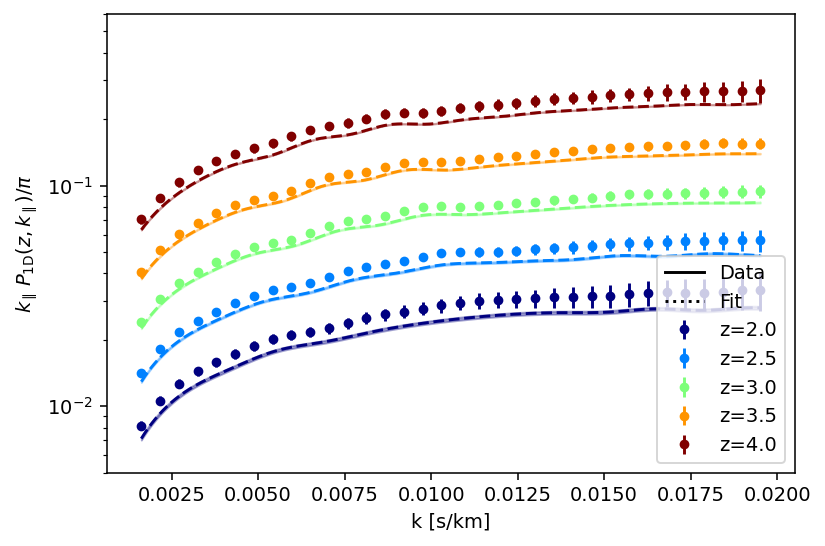

In [11]:
like.plot_p1d(plot_every_iz=2)

# Run iminuit minimiser

In [12]:
from iminuit import Minuit

In [13]:
#m = Minuit.from_array_func(like.get_chi2,theta,error=0.1,errordef=1)
m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.02,errordef=0.5)

In [14]:
# run optimiser
m.migrad()

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 35.9                    |     Ncalls=437 (437 total)     |
| EDM = 4.31e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.22    |   0.05    |            |            |         |         |       |
| 1 | x1   |   0.53    |   0.07    |            |            |         |         |       |
| 2 | x2   |   0.755   |   0.023   |            |            |         |         |       |
| 3 | x3   |   0.28    |   0.33    |            |            |         |         |       |
| 4 | x4   |   0.24    |   0.09    |            |            |         |         |       |
| 5 | x5   |   0.47    |   0.05    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [15]:
# access results again
print('best fit values =',m.values)
m.get_fmin()

best fit values = <ValueView of Minuit at 7fee5a040488>
  x0: 0.21588164461586937
  x1: 0.5314118917258364
  x2: 0.7552505191507303
  x3: 0.2801945445504896
  x4: 0.23542332596241217
  x5: 0.4726776267131134


------------------------------------------------------------------
| FCN = 35.9                    |     Ncalls=437 (437 total)     |
| EDM = 4.31e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------

### Compare to truth

In [16]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 4.592682948854392
Delta2_star = 0.2896527782616499
n_star = -2.2977959870439646
ln_tau_0 = 0.1021002076602921
ln_sigT_kms_0 = -0.08792218217980417
ln_gamma_0 = -0.10583066961503514
ln_kF_0 = -0.010928949314754632


In [17]:
like.get_simulation_linP_params(test_sim_label)

{'f_star': 0.9813909211842693,
 'g_star': 0.9677508863420937,
 'linP_kms': poly1d([-0.10814533, -2.29861294, 15.92231369]),
 'Delta2_star': 0.30364823417031134,
 'n_star': -2.2986129401746167,
 'alpha_star': -0.21629065209715273}

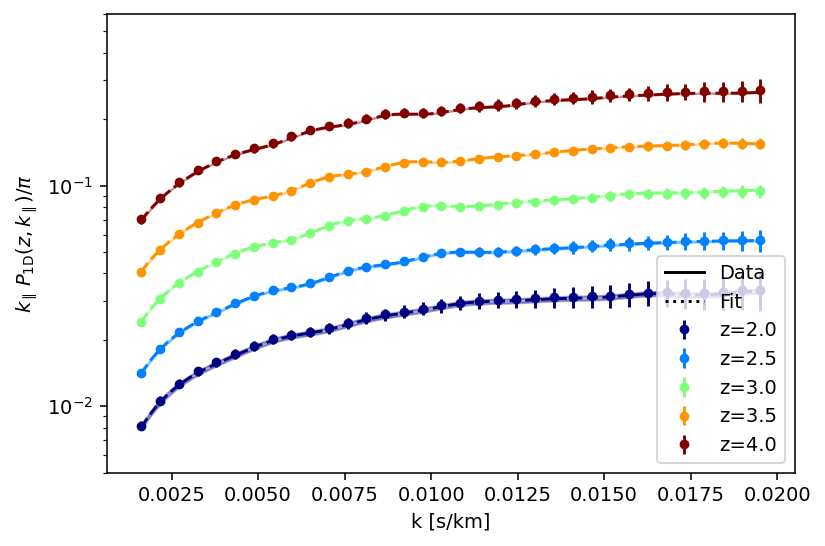

In [18]:
like.plot_p1d(plot_every_iz=2,values=m.values)